In [1]:
import datetime as dt
import logging
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import torch
import xarray as xr
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    xlab,
    ylab,
    theme,
    element_text,
)
from sklearn.gaussian_process import kernels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import (
    XArrayStandardScaler,
    SeasonalFeatures,
    XArrayFeatureUnion,
)
from src.step3_modeling.ensemble import DefaultEnsemble, BaggedXArrayRegressor
from src.step3_modeling.gaussian_process import (
    SklearnGPModel,
    LaggedSklearnGP,
    MultitaskGP,
)
from src.step3_modeling.var_models import VAR, NARX
from src.step3_modeling.metrics import summarize
from src.utils import create_rnbs_snapshot, flatten_array

logging.basicConfig(level=logging.INFO)

# device = "cuda"
device = "cpu"
torch.set_default_device(device)

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
lake_data = (
    load_data(["rnbs", "precip", "temp", "evap"])
    .sel(type="Basin")
    .dropna("Date")
    .to_array()
    .transpose("Date", "lake", ...)
)
lake_data

<xarray.DataArray (Date: 384, lake: 4, variable: 4)>
array([[[-20.92372 ,  24.8     , 266.2     ,  29.08    ],
        [ 40.5714  ,  42.78    , 266.3     ,  40.95    ],
        [ 93.83467 ,  13.33    , 258.3     ,  57.94    ],
        [239.5306  ,  46.5     , 526.5     ,  89.74    ]],

       [[ 33.66357 ,  14.56    , 263.9     ,  24.95    ],
        [ 39.75065 ,  16.8     , 261.1     ,  35.42    ],
        [145.7005  ,  16.8     , 258.4     ,  34.3     ],
        [ 92.36002 ,  24.92    , 522.4     ,  68.1     ]],

       [[139.9274  ,  28.21    , 274.2     ,  29.88    ],
        [234.0305  ,  22.32    , 274.2     ,  32.27    ],
        [278.341   ,  35.03    , 267.1     ,  35.06    ],
        [446.8436  ,  68.2     , 541.7     ,  59.49    ]],

       ...,

       [[-34.00105 ,  18.29    , 285.3     ,  55.55    ],
        [-47.44791 ,  23.25    , 283.6     ,  62.46    ],
        [-45.33585 ,  19.84    , 280.5     ,  53.57    ],
        [116.2634  ,  32.24    , 566.2     , 120.5     ]],

       [[  3.796643,  27.6     , 278.5     ,  37.59    ],
        [-13.97484 ,  26.7     , 277.3     ,  45.81    ],
        [-10.20312 ,  25.2     , 274.1     ,  54.42    ],
        [142.3357  ,  37.5     , 553.3     , 100.35    ]],

       [[-53.29011 ,  16.12    , 269.9     ,  42.62    ],
        [ -2.97982 ,  28.83    , 269.4     ,  53.72    ],
        [  0.      ,  13.64    , 266.5     ,  59.74    ],
        [173.6947  ,  35.34    , 538.      , 114.91    ]]])
Coordinates:
  * Date      (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 2010-12-01
  * lake      (lake) object 'sup' 'mic_hur' 'eri' 'ont'
    type      <U5 'Basin'
  * variable  (variable) object 'rnbs' 'precip' 'temp' 'evap'
Attributes:
    source:   GLCC

In [3]:
num_splits = 12
forecast_steps = 6
splitter = TimeSeriesSplit(n_splits=num_splits, test_size=forecast_steps)

splits = list(splitter.split(lake_data))

X, y = lake_data.sel(variable=["precip", "temp", "evap"]).drop("type"), lake_data.sel(
    variable=["rnbs"]
).squeeze().drop(["type", "variable"])

y = XArrayStandardScaler().fit_transform(y)
X, y

(<xarray.DataArray (Date: 384, lake: 4, variable: 3)>
 array([[[ 24.8 , 266.2 ,  29.08],
         [ 42.78, 266.3 ,  40.95],
         [ 13.33, 258.3 ,  57.94],
         [ 46.5 , 526.5 ,  89.74]],
 
        [[ 14.56, 263.9 ,  24.95],
         [ 16.8 , 261.1 ,  35.42],
         [ 16.8 , 258.4 ,  34.3 ],
         [ 24.92, 522.4 ,  68.1 ]],
 
        [[ 28.21, 274.2 ,  29.88],
         [ 22.32, 274.2 ,  32.27],
         [ 35.03, 267.1 ,  35.06],
         [ 68.2 , 541.7 ,  59.49]],
 
        ...,
 
        [[ 18.29, 285.3 ,  55.55],
         [ 23.25, 283.6 ,  62.46],
         [ 19.84, 280.5 ,  53.57],
         [ 32.24, 566.2 , 120.5 ]],
 
        [[ 27.6 , 278.5 ,  37.59],
         [ 26.7 , 277.3 ,  45.81],
         [ 25.2 , 274.1 ,  54.42],
         [ 37.5 , 553.3 , 100.35]],
 
        [[ 16.12, 269.9 ,  42.62],
         [ 28.83, 269.4 ,  53.72],
         [ 13.64, 266.5 ,  59.74],
         [ 35.34, 538.  , 114.91]]])
 Coordinates:
   * Date      (Date) datetime64[ns] 1979-01-01 1979-02-01 .

In [5]:
preprocessor = XArrayFeatureUnion(
    [
        (
            "preprocess",
            Pipeline(
                steps=[
                    ("scale", XArrayStandardScaler()),
                    ("flatten", FunctionTransformer(flatten_array)),
                ]
            ),
        ),
        ("seasonal", SeasonalFeatures()),
    ]
)

gp_models = {
    "GP_Matern": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "model",
                SklearnGPModel(
                    1.0 * kernels.Matern(nu=1.5) * kernels.RationalQuadratic()
                ),
            ),
        ]
    ),
    "GP_MaternLag": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "model",
                LaggedSklearnGP(
                    1.0 * kernels.Matern(nu=1.5) * kernels.RationalQuadratic()
                ),
            ),
        ]
    ),
    "MultitaskGP": Pipeline(
        steps=[("preprocess", preprocessor), ("model", MultitaskGP(epochs=100, rank=2))]
    ),
}

varx_models = {
    "VARX": Pipeline(
        steps=[
            ("preprocess", XArrayStandardScaler()),
            (
                "model",
                VAR(
                    lags={"y": 3, "precip": 2, "temp": 2, "evap": 3},
                    num_warmup=1500,
                    num_chains=4,
                    num_samples=1000,
                ),
            ),
        ]
    ),
    # "NARX": Pipeline(
    #     steps=[
    #         ("preprocess", XArrayStandardScaler()),
    #         (
    #             "model",
    #             NARX(
    #                 lags={"y": 3, "temp": 2, "precip": 2, "evap": 3},
    #                 num_warmup=3000,
    #                 num_chains=4,
    #                 num_samples=1000,
    #             ),
    #         ),
    #     ]
    # ),
}

# use only temp and precip
all_models = {
    "Default": Pipeline(
        steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]
    ),
    **gp_models,
    **varx_models,
}

In [6]:
# for name, model in all_models.items():
train_id, test_id = splits[0]

# run cross validated
results = []
for name, model in all_models.items():
    logging.info(f"Fitting {name} model...")
    for i, (train_id, test_id) in enumerate(splits):
        logging.info(f"Fitting {name} model (split {i + 1}/{num_splits})")
        # X[train_id], y[train_id]
        model.fit(X[train_id], y[train_id])
        preds = model.predict(
            X[: max(test_id) + 1],
            y=y[: max(test_id) + 1],
            forecast_steps=forecast_steps,
        )

        array = xr.concat(
            [preds, y[test_id].expand_dims({"value": ["true"]}, axis=-1)], dim="value"
        )

        predictions = pd.concat(
            [
                arr.to_pandas().assign(
                    months_ahead=list(range(1, forecast_steps + 1)), model=name
                )
                for arr in array.transpose("lake", ...)
            ],
            axis=0,
            keys=preds.lake.values,
            names=["lake"],
        )
        results.append(predictions)

cv_results = pd.concat(results, axis=0)

INFO:root:Fitting Default model...
INFO:root:Fitting Default model (split 1/12)
INFO:root:Fitting Default model (split 2/12)
INFO:root:Fitting Default model (split 3/12)
INFO:root:Fitting Default model (split 4/12)
INFO:root:Fitting Default model (split 5/12)
INFO:root:Fitting Default model (split 6/12)
INFO:root:Fitting Default model (split 7/12)
INFO:root:Fitting Default model (split 8/12)
INFO:root:Fitting Default model (split 9/12)
INFO:root:Fitting Default model (split 10/12)
INFO:root:Fitting Default model (split 11/12)
INFO:root:Fitting Default model (split 12/12)
INFO:root:Fitting GP_Matern model...
INFO:root:Fitting GP_Matern model (split 1/12)
INFO:root:Fitting GP_Matern model (split 2/12)
INFO:root:Fitting GP_Matern model (split 3/12)
INFO:root:Fitting GP_Matern model (split 4/12)
INFO:root:Fitting GP_Matern model (split 5/12)
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value f

Iter 1/100 - Loss: 1.601
Iter 2/100 - Loss: 1.543
Iter 3/100 - Loss: 1.482
Iter 4/100 - Loss: 1.421
Iter 5/100 - Loss: 1.364
Iter 6/100 - Loss: 1.310
Iter 7/100 - Loss: 1.260
Iter 8/100 - Loss: 1.213
Iter 9/100 - Loss: 1.166
Iter 10/100 - Loss: 1.120
Iter 11/100 - Loss: 1.075
Iter 12/100 - Loss: 1.033
Iter 13/100 - Loss: 0.995
Iter 14/100 - Loss: 0.959
Iter 15/100 - Loss: 0.926
Iter 16/100 - Loss: 0.893
Iter 17/100 - Loss: 0.861
Iter 18/100 - Loss: 0.828
Iter 19/100 - Loss: 0.795
Iter 20/100 - Loss: 0.762
Iter 21/100 - Loss: 0.731
Iter 22/100 - Loss: 0.703
Iter 23/100 - Loss: 0.681
Iter 24/100 - Loss: 0.663
Iter 25/100 - Loss: 0.647
Iter 26/100 - Loss: 0.631
Iter 27/100 - Loss: 0.616
Iter 28/100 - Loss: 0.605
Iter 29/100 - Loss: 0.596
Iter 30/100 - Loss: 0.589
Iter 31/100 - Loss: 0.584
Iter 32/100 - Loss: 0.580
Iter 33/100 - Loss: 0.578
Iter 34/100 - Loss: 0.576
Iter 35/100 - Loss: 0.576
Iter 36/100 - Loss: 0.577
Iter 37/100 - Loss: 0.577
Iter 38/100 - Loss: 0.577
Iter 39/100 - Loss: 0

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538194616/work/torch/csrc/utils/tensor_new.cpp:643.)
INFO:root:Fitting MultitaskGP model (split 2/12)


Iter 92/100 - Loss: 0.549
Iter 93/100 - Loss: 0.549
Iter 94/100 - Loss: 0.549
Iter 95/100 - Loss: 0.548
Iter 96/100 - Loss: 0.548
Iter 97/100 - Loss: 0.548
Iter 98/100 - Loss: 0.548
Iter 99/100 - Loss: 0.548
Iter 100/100 - Loss: 0.548
Iter 1/100 - Loss: 1.569
Iter 2/100 - Loss: 1.517
Iter 3/100 - Loss: 1.464
Iter 4/100 - Loss: 1.411
Iter 5/100 - Loss: 1.356
Iter 6/100 - Loss: 1.301
Iter 7/100 - Loss: 1.248
Iter 8/100 - Loss: 1.196
Iter 9/100 - Loss: 1.148
Iter 10/100 - Loss: 1.103
Iter 11/100 - Loss: 1.063
Iter 12/100 - Loss: 1.028
Iter 13/100 - Loss: 0.993
Iter 14/100 - Loss: 0.957
Iter 15/100 - Loss: 0.919
Iter 16/100 - Loss: 0.882
Iter 17/100 - Loss: 0.847
Iter 18/100 - Loss: 0.812
Iter 19/100 - Loss: 0.778
Iter 20/100 - Loss: 0.748
Iter 21/100 - Loss: 0.720
Iter 22/100 - Loss: 0.695
Iter 23/100 - Loss: 0.672
Iter 24/100 - Loss: 0.651
Iter 25/100 - Loss: 0.633
Iter 26/100 - Loss: 0.618
Iter 27/100 - Loss: 0.606
Iter 28/100 - Loss: 0.597
Iter 29/100 - Loss: 0.589
Iter 30/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 3/12)


Iter 1/100 - Loss: 1.643
Iter 2/100 - Loss: 1.589
Iter 3/100 - Loss: 1.531
Iter 4/100 - Loss: 1.472
Iter 5/100 - Loss: 1.411
Iter 6/100 - Loss: 1.351
Iter 7/100 - Loss: 1.292
Iter 8/100 - Loss: 1.234
Iter 9/100 - Loss: 1.176
Iter 10/100 - Loss: 1.122
Iter 11/100 - Loss: 1.074
Iter 12/100 - Loss: 1.034
Iter 13/100 - Loss: 0.999
Iter 14/100 - Loss: 0.966
Iter 15/100 - Loss: 0.930
Iter 16/100 - Loss: 0.893
Iter 17/100 - Loss: 0.854
Iter 18/100 - Loss: 0.817
Iter 19/100 - Loss: 0.782
Iter 20/100 - Loss: 0.750
Iter 21/100 - Loss: 0.721
Iter 22/100 - Loss: 0.696
Iter 23/100 - Loss: 0.673
Iter 24/100 - Loss: 0.651
Iter 25/100 - Loss: 0.632
Iter 26/100 - Loss: 0.617
Iter 27/100 - Loss: 0.605
Iter 28/100 - Loss: 0.597
Iter 29/100 - Loss: 0.590
Iter 30/100 - Loss: 0.585
Iter 31/100 - Loss: 0.581
Iter 32/100 - Loss: 0.577
Iter 33/100 - Loss: 0.575
Iter 34/100 - Loss: 0.574
Iter 35/100 - Loss: 0.574
Iter 36/100 - Loss: 0.574
Iter 37/100 - Loss: 0.574
Iter 38/100 - Loss: 0.573
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 4/12)


Iter 98/100 - Loss: 0.540
Iter 99/100 - Loss: 0.540
Iter 100/100 - Loss: 0.540
Iter 1/100 - Loss: 1.692
Iter 2/100 - Loss: 1.642
Iter 3/100 - Loss: 1.588
Iter 4/100 - Loss: 1.531
Iter 5/100 - Loss: 1.472
Iter 6/100 - Loss: 1.411
Iter 7/100 - Loss: 1.349
Iter 8/100 - Loss: 1.288
Iter 9/100 - Loss: 1.228
Iter 10/100 - Loss: 1.169
Iter 11/100 - Loss: 1.112
Iter 12/100 - Loss: 1.058
Iter 13/100 - Loss: 1.007
Iter 14/100 - Loss: 0.960
Iter 15/100 - Loss: 0.917
Iter 16/100 - Loss: 0.879
Iter 17/100 - Loss: 0.845
Iter 18/100 - Loss: 0.816
Iter 19/100 - Loss: 0.788
Iter 20/100 - Loss: 0.760
Iter 21/100 - Loss: 0.733
Iter 22/100 - Loss: 0.708
Iter 23/100 - Loss: 0.685
Iter 24/100 - Loss: 0.664
Iter 25/100 - Loss: 0.645
Iter 26/100 - Loss: 0.628
Iter 27/100 - Loss: 0.613
Iter 28/100 - Loss: 0.600
Iter 29/100 - Loss: 0.590
Iter 30/100 - Loss: 0.581
Iter 31/100 - Loss: 0.573
Iter 32/100 - Loss: 0.566
Iter 33/100 - Loss: 0.562
Iter 34/100 - Loss: 0.562
Iter 35/100 - Loss: 0.563
Iter 36/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 5/12)


Iter 97/100 - Loss: 0.533
Iter 98/100 - Loss: 0.533
Iter 99/100 - Loss: 0.533
Iter 100/100 - Loss: 0.533
Iter 1/100 - Loss: 1.576
Iter 2/100 - Loss: 1.525
Iter 3/100 - Loss: 1.474
Iter 4/100 - Loss: 1.423
Iter 5/100 - Loss: 1.371
Iter 6/100 - Loss: 1.317
Iter 7/100 - Loss: 1.263
Iter 8/100 - Loss: 1.211
Iter 9/100 - Loss: 1.161
Iter 10/100 - Loss: 1.115
Iter 11/100 - Loss: 1.071
Iter 12/100 - Loss: 1.030
Iter 13/100 - Loss: 0.993
Iter 14/100 - Loss: 0.957
Iter 15/100 - Loss: 0.921
Iter 16/100 - Loss: 0.886
Iter 17/100 - Loss: 0.851
Iter 18/100 - Loss: 0.818
Iter 19/100 - Loss: 0.786
Iter 20/100 - Loss: 0.755
Iter 21/100 - Loss: 0.726
Iter 22/100 - Loss: 0.702
Iter 23/100 - Loss: 0.681
Iter 24/100 - Loss: 0.663
Iter 25/100 - Loss: 0.645
Iter 26/100 - Loss: 0.629
Iter 27/100 - Loss: 0.614
Iter 28/100 - Loss: 0.603
Iter 29/100 - Loss: 0.593
Iter 30/100 - Loss: 0.585
Iter 31/100 - Loss: 0.579
Iter 32/100 - Loss: 0.575
Iter 33/100 - Loss: 0.573
Iter 34/100 - Loss: 0.572
Iter 35/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 6/12)


Iter 96/100 - Loss: 0.543
Iter 97/100 - Loss: 0.543
Iter 98/100 - Loss: 0.543
Iter 99/100 - Loss: 0.543
Iter 100/100 - Loss: 0.543
Iter 1/100 - Loss: 1.537
Iter 2/100 - Loss: 1.482
Iter 3/100 - Loss: 1.425
Iter 4/100 - Loss: 1.369
Iter 5/100 - Loss: 1.317
Iter 6/100 - Loss: 1.268
Iter 7/100 - Loss: 1.226
Iter 8/100 - Loss: 1.188
Iter 9/100 - Loss: 1.152
Iter 10/100 - Loss: 1.115
Iter 11/100 - Loss: 1.075
Iter 12/100 - Loss: 1.035
Iter 13/100 - Loss: 0.994
Iter 14/100 - Loss: 0.954
Iter 15/100 - Loss: 0.914
Iter 16/100 - Loss: 0.876
Iter 17/100 - Loss: 0.840
Iter 18/100 - Loss: 0.807
Iter 19/100 - Loss: 0.776
Iter 20/100 - Loss: 0.747
Iter 21/100 - Loss: 0.719
Iter 22/100 - Loss: 0.692
Iter 23/100 - Loss: 0.668
Iter 24/100 - Loss: 0.648
Iter 25/100 - Loss: 0.631
Iter 26/100 - Loss: 0.616
Iter 27/100 - Loss: 0.603
Iter 28/100 - Loss: 0.593
Iter 29/100 - Loss: 0.585
Iter 30/100 - Loss: 0.579
Iter 31/100 - Loss: 0.574
Iter 32/100 - Loss: 0.571
Iter 33/100 - Loss: 0.569
Iter 34/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 7/12)


Iter 96/100 - Loss: 0.539
Iter 97/100 - Loss: 0.539
Iter 98/100 - Loss: 0.539
Iter 99/100 - Loss: 0.539
Iter 100/100 - Loss: 0.539
Iter 1/100 - Loss: 1.630
Iter 2/100 - Loss: 1.578
Iter 3/100 - Loss: 1.527
Iter 4/100 - Loss: 1.476
Iter 5/100 - Loss: 1.426
Iter 6/100 - Loss: 1.374
Iter 7/100 - Loss: 1.322
Iter 8/100 - Loss: 1.273
Iter 9/100 - Loss: 1.226
Iter 10/100 - Loss: 1.181
Iter 11/100 - Loss: 1.135
Iter 12/100 - Loss: 1.090
Iter 13/100 - Loss: 1.044
Iter 14/100 - Loss: 0.998
Iter 15/100 - Loss: 0.954
Iter 16/100 - Loss: 0.913
Iter 17/100 - Loss: 0.876
Iter 18/100 - Loss: 0.843
Iter 19/100 - Loss: 0.811
Iter 20/100 - Loss: 0.780
Iter 21/100 - Loss: 0.749
Iter 22/100 - Loss: 0.721
Iter 23/100 - Loss: 0.695
Iter 24/100 - Loss: 0.671
Iter 25/100 - Loss: 0.649
Iter 26/100 - Loss: 0.629
Iter 27/100 - Loss: 0.611
Iter 28/100 - Loss: 0.595
Iter 29/100 - Loss: 0.583
Iter 30/100 - Loss: 0.575
Iter 31/100 - Loss: 0.569
Iter 32/100 - Loss: 0.565
Iter 33/100 - Loss: 0.564
Iter 34/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 8/12)


Iter 99/100 - Loss: 0.540
Iter 100/100 - Loss: 0.540
Iter 1/100 - Loss: 1.659
Iter 2/100 - Loss: 1.610
Iter 3/100 - Loss: 1.559
Iter 4/100 - Loss: 1.507
Iter 5/100 - Loss: 1.457
Iter 6/100 - Loss: 1.407
Iter 7/100 - Loss: 1.358
Iter 8/100 - Loss: 1.309
Iter 9/100 - Loss: 1.260
Iter 10/100 - Loss: 1.210
Iter 11/100 - Loss: 1.159
Iter 12/100 - Loss: 1.109
Iter 13/100 - Loss: 1.061
Iter 14/100 - Loss: 1.014
Iter 15/100 - Loss: 0.968
Iter 16/100 - Loss: 0.924
Iter 17/100 - Loss: 0.883
Iter 18/100 - Loss: 0.844
Iter 19/100 - Loss: 0.809
Iter 20/100 - Loss: 0.778
Iter 21/100 - Loss: 0.748
Iter 22/100 - Loss: 0.722
Iter 23/100 - Loss: 0.698
Iter 24/100 - Loss: 0.676
Iter 25/100 - Loss: 0.656
Iter 26/100 - Loss: 0.637
Iter 27/100 - Loss: 0.620
Iter 28/100 - Loss: 0.606
Iter 29/100 - Loss: 0.593
Iter 30/100 - Loss: 0.583
Iter 31/100 - Loss: 0.576
Iter 32/100 - Loss: 0.570
Iter 33/100 - Loss: 0.567
Iter 34/100 - Loss: 0.565
Iter 35/100 - Loss: 0.564
Iter 36/100 - Loss: 0.564
Iter 37/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 9/12)


Iter 99/100 - Loss: 0.546
Iter 100/100 - Loss: 0.546
Iter 1/100 - Loss: 1.653
Iter 2/100 - Loss: 1.607
Iter 3/100 - Loss: 1.558
Iter 4/100 - Loss: 1.508
Iter 5/100 - Loss: 1.456
Iter 6/100 - Loss: 1.402
Iter 7/100 - Loss: 1.346
Iter 8/100 - Loss: 1.289
Iter 9/100 - Loss: 1.232
Iter 10/100 - Loss: 1.175
Iter 11/100 - Loss: 1.119
Iter 12/100 - Loss: 1.066
Iter 13/100 - Loss: 1.017
Iter 14/100 - Loss: 0.974
Iter 15/100 - Loss: 0.935
Iter 16/100 - Loss: 0.901
Iter 17/100 - Loss: 0.868
Iter 18/100 - Loss: 0.837
Iter 19/100 - Loss: 0.807
Iter 20/100 - Loss: 0.776
Iter 21/100 - Loss: 0.745
Iter 22/100 - Loss: 0.714
Iter 23/100 - Loss: 0.685
Iter 24/100 - Loss: 0.660
Iter 25/100 - Loss: 0.639
Iter 26/100 - Loss: 0.622
Iter 27/100 - Loss: 0.608
Iter 28/100 - Loss: 0.596
Iter 29/100 - Loss: 0.586
Iter 30/100 - Loss: 0.578
Iter 31/100 - Loss: 0.571
Iter 32/100 - Loss: 0.566
Iter 33/100 - Loss: 0.564
Iter 34/100 - Loss: 0.563
Iter 35/100 - Loss: 0.564
Iter 36/100 - Loss: 0.565
Iter 37/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 10/12)


Iter 97/100 - Loss: 0.543
Iter 98/100 - Loss: 0.543
Iter 99/100 - Loss: 0.542
Iter 100/100 - Loss: 0.542
Iter 1/100 - Loss: 1.612
Iter 2/100 - Loss: 1.562
Iter 3/100 - Loss: 1.509
Iter 4/100 - Loss: 1.455
Iter 5/100 - Loss: 1.401
Iter 6/100 - Loss: 1.347
Iter 7/100 - Loss: 1.295
Iter 8/100 - Loss: 1.244
Iter 9/100 - Loss: 1.192
Iter 10/100 - Loss: 1.140
Iter 11/100 - Loss: 1.090
Iter 12/100 - Loss: 1.041
Iter 13/100 - Loss: 0.995
Iter 14/100 - Loss: 0.953
Iter 15/100 - Loss: 0.916
Iter 16/100 - Loss: 0.881
Iter 17/100 - Loss: 0.848
Iter 18/100 - Loss: 0.817
Iter 19/100 - Loss: 0.785
Iter 20/100 - Loss: 0.754
Iter 21/100 - Loss: 0.722
Iter 22/100 - Loss: 0.693
Iter 23/100 - Loss: 0.668
Iter 24/100 - Loss: 0.646
Iter 25/100 - Loss: 0.628
Iter 26/100 - Loss: 0.613
Iter 27/100 - Loss: 0.600
Iter 28/100 - Loss: 0.591
Iter 29/100 - Loss: 0.583
Iter 30/100 - Loss: 0.578
Iter 31/100 - Loss: 0.574
Iter 32/100 - Loss: 0.571
Iter 33/100 - Loss: 0.570
Iter 34/100 - Loss: 0.570
Iter 35/100 - Loss: 

INFO:root:Fitting MultitaskGP model (split 11/12)


Iter 1/100 - Loss: 1.544
Iter 2/100 - Loss: 1.488
Iter 3/100 - Loss: 1.433
Iter 4/100 - Loss: 1.381
Iter 5/100 - Loss: 1.327
Iter 6/100 - Loss: 1.271
Iter 7/100 - Loss: 1.214
Iter 8/100 - Loss: 1.162
Iter 9/100 - Loss: 1.115
Iter 10/100 - Loss: 1.075
Iter 11/100 - Loss: 1.041
Iter 12/100 - Loss: 1.009
Iter 13/100 - Loss: 0.977
Iter 14/100 - Loss: 0.945
Iter 15/100 - Loss: 0.912
Iter 16/100 - Loss: 0.878
Iter 17/100 - Loss: 0.845
Iter 18/100 - Loss: 0.812
Iter 19/100 - Loss: 0.780
Iter 20/100 - Loss: 0.750
Iter 21/100 - Loss: 0.720
Iter 22/100 - Loss: 0.692
Iter 23/100 - Loss: 0.667
Iter 24/100 - Loss: 0.647
Iter 25/100 - Loss: 0.633
Iter 26/100 - Loss: 0.621
Iter 27/100 - Loss: 0.610
Iter 28/100 - Loss: 0.601
Iter 29/100 - Loss: 0.593
Iter 30/100 - Loss: 0.586
Iter 31/100 - Loss: 0.581
Iter 32/100 - Loss: 0.576
Iter 33/100 - Loss: 0.573
Iter 34/100 - Loss: 0.570
Iter 35/100 - Loss: 0.569
Iter 36/100 - Loss: 0.568
Iter 37/100 - Loss: 0.567
Iter 38/100 - Loss: 0.567
Iter 39/100 - Loss: 0

INFO:root:Fitting MultitaskGP model (split 12/12)


Iter 97/100 - Loss: 0.544
Iter 98/100 - Loss: 0.544
Iter 99/100 - Loss: 0.544
Iter 100/100 - Loss: 0.544
Iter 1/100 - Loss: 1.731
Iter 2/100 - Loss: 1.682
Iter 3/100 - Loss: 1.631
Iter 4/100 - Loss: 1.581
Iter 5/100 - Loss: 1.531
Iter 6/100 - Loss: 1.480
Iter 7/100 - Loss: 1.427
Iter 8/100 - Loss: 1.372
Iter 9/100 - Loss: 1.316
Iter 10/100 - Loss: 1.260
Iter 11/100 - Loss: 1.204
Iter 12/100 - Loss: 1.149
Iter 13/100 - Loss: 1.095
Iter 14/100 - Loss: 1.043
Iter 15/100 - Loss: 0.994
Iter 16/100 - Loss: 0.948
Iter 17/100 - Loss: 0.904
Iter 18/100 - Loss: 0.863
Iter 19/100 - Loss: 0.827
Iter 20/100 - Loss: 0.794
Iter 21/100 - Loss: 0.764
Iter 22/100 - Loss: 0.736
Iter 23/100 - Loss: 0.707
Iter 24/100 - Loss: 0.680
Iter 25/100 - Loss: 0.655
Iter 26/100 - Loss: 0.634
Iter 27/100 - Loss: 0.617
Iter 28/100 - Loss: 0.603
Iter 29/100 - Loss: 0.592
Iter 30/100 - Loss: 0.584
Iter 31/100 - Loss: 0.578
Iter 32/100 - Loss: 0.574
Iter 33/100 - Loss: 0.571
Iter 34/100 - Loss: 0.570
Iter 35/100 - Loss: 

INFO:root:Fitting VARX model...
INFO:root:Fitting VARX model (split 1/12)
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/mcanearm/miniconda3/envs/noaa_mvp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Iter 98/100 - Loss: 0.543
Iter 99/100 - Loss: 0.543
Iter 100/100 - Loss: 0.543


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 2/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 3/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 4/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 5/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 6/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 7/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 8/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 9/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 10/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 11/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Fitting VARX model (split 12/12)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [10]:
cv_results.groupby(["lake", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  interval_len  \
lake    model                                                                
eri     Default       0.727128  0.527995 -0.026825  0.875000      2.244687   
        GP_Matern     0.420429  0.174586 -0.046636  0.930556      1.553434   
        GP_MaternLag  0.465333  0.213958 -0.050755  0.902778      1.624338   
        MultitaskGP   0.459393  0.208401 -0.051397  0.916667      1.675457   
        NARX          0.706330  0.496159  0.052372  0.916667      1.694664   
        VARX          0.451730  0.202085 -0.044440  0.888889      1.491768   
mic_hur Default       0.683238  0.457292  0.097579  0.888889      2.222746   
        GP_Matern     0.382363  0.146202  0.000047  0.972222      1.553434   
        GP_MaternLag  0.425676  0.180310  0.029819  0.972222      1.624338   
        MultitaskGP   0.408294  0.166600 -0.010208  0.930556      1.443985   
        NARX          0.476057  0.226625  0.002348  0.916667      1.520164   
        VARX          0.363776  0.132331 -0.001428  0.875000      1.163790   
ont     Default       0.641845  0.398415 -0.116404  0.930556      2.204409   
        GP_Matern     0.433245  0.170544 -0.130987  0.944444      1.553434   
        GP_MaternLag  0.421161  0.170230 -0.084537  0.944444      1.624338   
        MultitaskGP   0.466461  0.195169 -0.149722  0.944444      1.687247   
        NARX          0.898753  0.807503  0.015908  0.916667      1.585300   
        VARX          0.386909  0.145325 -0.066132  0.930556      1.388413   
sup     Default       0.672807  0.411000  0.204132  0.833333      1.994818   
        GP_Matern     0.439355  0.172416  0.143586  0.902778      1.553434   
        GP_MaternLag  0.430039  0.174832  0.100507  0.902778      1.624338   
        MultitaskGP   0.444184  0.179697  0.132673  0.916667      1.495866   
        NARX          0.589470  0.316638  0.175607  0.861111      1.477141   
        VARX          0.423043  0.161931  0.130516  0.875000      1.215122   

                          crps     N        r2  
lake    model                                   
eri     Default       0.409042  72.0  0.009383  
        GP_Matern     0.237764  72.0  0.774161  
        GP_MaternLag  0.264131  72.0  0.684727  
        MultitaskGP   0.258191  72.0  0.738818  
        NARX          0.438147  72.0  0.569712  
        VARX          0.252168  72.0  0.723717  
mic_hur Default       0.399347  72.0  0.201659  
        GP_Matern     0.211383  72.0  0.794973  
        GP_MaternLag  0.240125  72.0  0.699167  
        MultitaskGP   0.224213  72.0  0.771477  
        NARX          0.287427  72.0  0.661531  
        VARX          0.203095  72.0  0.810957  
ont     Default       0.360449  72.0  0.316100  
        GP_Matern     0.229611  72.0  0.674579  
        GP_MaternLag  0.225976  72.0  0.667920  
        MultitaskGP   0.248925  72.0  0.655601  
        NARX          0.479119  72.0  0.422331  
        VARX          0.217847  72.0  0.773410  
sup     Default       0.365079  72.0  0.311531  
        GP_Matern     0.242923  72.0  0.784862  
        GP_MaternLag  0.237916  72.0  0.777444  
        MultitaskGP   0.245327  72.0  0.775759  
        NARX          0.356319  72.0  0.654359  
        VARX          0.228042  72.0  0.796806

In [11]:
cv_results.groupby(["model"]).apply(summarize, include_groups=False)

,rmse,variance,bias,coverage,interval_len,crps,N,r2
model,,,,,,,,
Default,0.681939,0.463471,0.039620,0.881944,2.166665,0.383479,288.0,0.218085
GP_Matern,0.419433,0.175852,-0.008497,0.937500,1.553434,0.230420,288.0,0.763310
GP_MaternLag,0.435903,0.190010,-0.001242,0.930556,1.624338,0.242037,288.0,0.714282
MultitaskGP,0.445149,0.197771,-0.019663,0.927083,1.575639,0.244164,288.0,0.740334
NARX,0.685705,0.466402,0.061559,0.902778,1.569317,0.390253,288.0,0.558372
VARX,0.407755,0.166243,0.004629,0.892361,1.314773,0.225288,288.0,0.777513


In [12]:
cv_results.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  \
months_ahead model                                                  
1            Default       0.713942  0.475293 -0.185526  0.895833   
             GP_Matern     0.472579  0.214207 -0.095519  0.895833   
             GP_MaternLag  0.436127  0.183670 -0.080851  0.895833   
             MultitaskGP   0.528662  0.275442 -0.063574  0.812500   
             NARX          0.471772  0.213808 -0.093601  0.854167   
             VARX          0.463220  0.206723 -0.088601  0.875000   
2            Default       0.695546  0.481177  0.051062  0.791667   
             GP_Matern     0.363268  0.120984  0.104782  0.916667   
             GP_MaternLag  0.395755  0.135079  0.146775  0.937500   
             MultitaskGP   0.396379  0.152890  0.065011  0.937500   
             NARX          0.459892  0.162960  0.220319  0.895833   
             VARX          0.408759  0.157981  0.095409  0.854167   
3            Default       0.537387  0.278315  0.102319  0.937500   
             GP_Matern     0.331504  0.108107  0.042277  0.979167   
             GP_MaternLag  0.401984  0.156449  0.071711  0.958333   
             MultitaskGP   0.336783  0.112462  0.030997  1.000000   
             NARX          0.475057  0.223442  0.047306  0.937500   
             VARX          0.388831  0.140866  0.101608  0.895833   
4            Default       0.860412  0.733446  0.082848  0.791667   
             GP_Matern     0.571142  0.319056 -0.084540  0.875000   
             GP_MaternLag  0.596530  0.349602 -0.079032  0.854167   
             MultitaskGP   0.572274  0.323080 -0.066459  0.875000   
             NARX          0.613434  0.367568 -0.093447  0.812500   
             VARX          0.510550  0.260266 -0.019887  0.833333   
5            Default       0.596471  0.290947  0.254619  0.916667   
             GP_Matern     0.402870  0.160263  0.045174  0.958333   
             GP_MaternLag  0.395722  0.151863  0.068792  0.937500   
             MultitaskGP   0.433899  0.188077 -0.013824  0.958333   
             NARX          0.424845  0.174641  0.076501  0.916667   
             VARX          0.365275  0.133306 -0.010928  0.916667   
6            Default       0.641775  0.407305 -0.067600  0.958333   
             GP_Matern     0.319137  0.097860 -0.063159  1.000000   
             GP_MaternLag  0.345257  0.101020 -0.134844  1.000000   
             MultitaskGP   0.350941  0.118241 -0.070132  0.979167   
             NARX          1.266729  1.559544  0.212272  1.000000   
             VARX          0.265801  0.068168 -0.049826  0.979167   

                           interval_len      crps     N        r2  
months_ahead model                                                 
1            Default           1.974050  0.397204  48.0 -1.021083  
             GP_Matern         1.542983  0.268718  48.0  0.586664  
             GP_MaternLag      1.519138  0.243078  48.0  0.674685  
             MultitaskGP       1.542531  0.296546  48.0  0.533201  
             NARX              1.426194  0.262572  48.0  0.612915  
             VARX              1.291392  0.249497  48.0  0.579215  
2            Default           1.913799  0.400559  48.0 -0.905448  
             GP_Matern         1.546254  0.198047  48.0  0.772143  
             GP_MaternLag      1.526061  0.217328  48.0  0.736844  
             MultitaskGP       1.552054  0.216776  48.0  0.718811  
             NARX              1.467327  0.263785  48.0  0.692840  
             VARX              1.312274  0.229902  48.0  0.745721  
3            Default           2.246366  0.302667  48.0  0.577433  
             GP_Matern         1.549889  0.188248  48.0  0.879747  
             GP_MaternLag      1.565235  0.228943  48.0  0.776429  
             MultitaskGP       1.579751  0.191257  48.0  0.874475  
             NARX              1.556419  0.264131  48.0  0.731319  
             VARX              1.307647  0.219935  48.0  0.820867  
4            Default           2.286621  0.49357

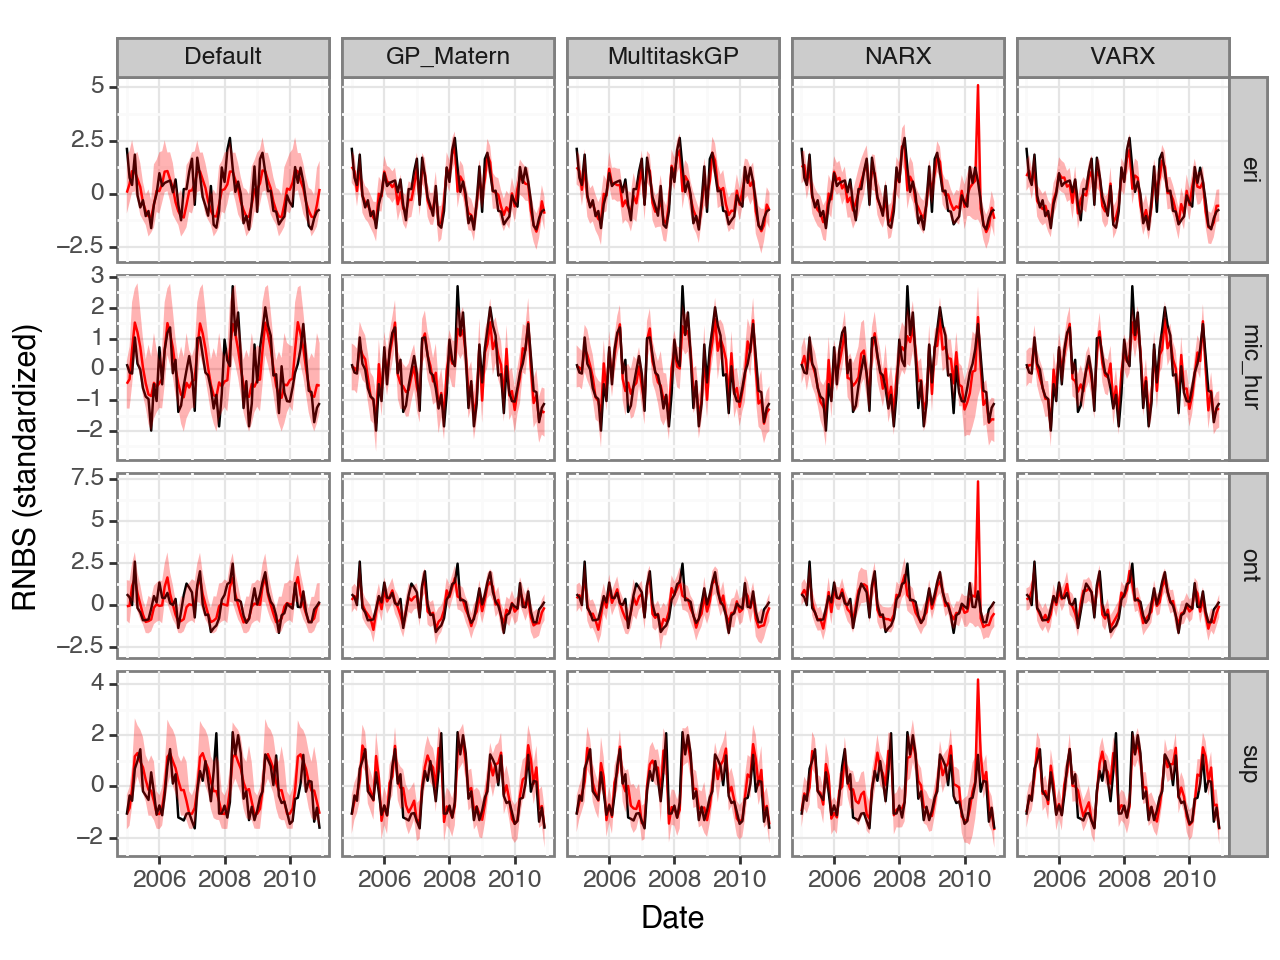

<Figure Size: (640 x 480)>

In [13]:
import warnings

warnings.filterwarnings("ignore")

plot_data = cv_results.reset_index()
plot_data = plot_data[
    plot_data["model"].isin(["Default", "GP_Matern", "MultitaskGP", "NARX", "VARX"])
]
(
    ggplot(data=plot_data.reset_index(), mapping=aes(x="Date", y="mean"))
    + geom_line(color="red")
    + geom_line(mapping=aes(x="Date", y="true"), color="black")
    + facet_grid("lake~model", scales="free_y")
    + scale_x_datetime(
        limits=[plot_data.Date.min(), plot_data.Date.max()],
        labels=date_format(fmt="%Y"),
        breaks=date_breaks("2 year"),
    )
    + geom_ribbon(
        mapping=aes(x="Date", ymin="lower", ymax="upper"),
        fill="red",
        alpha=0.3,
    )
    + ylab("RNBS (standardized)")
    + theme(text=element_text(size=12))
    + theme_bw()
)

In [15]:
model = varx_models["VARX"].steps[-1][1]
summarized = az.summary(model.trace, filter_vars="regex", var_names=["alpha"])

summarized[~((summarized["hdi_3%"] <= 0) & (summarized["hdi_97%"] >= 0))]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"evap_alpha[sup, eri]",-0.227,0.037,-0.298,-0.160,0.001,0.000,4966.0,3026.0,1.0
"evap_alpha[mic_hur, eri]",-0.101,0.035,-0.166,-0.035,0.001,0.000,4154.0,3060.0,1.0
"evap_alpha[mic_hur, ont]",-0.366,0.076,-0.504,-0.219,0.001,0.001,4651.0,2909.0,1.0
"evap_alpha[eri, sup]",-0.206,0.105,-0.412,-0.021,0.002,0.001,4700.0,3548.0,1.0
"evap_alpha[eri, ont]",-0.208,0.092,-0.379,-0.032,0.001,0.001,4651.0,3264.0,1.0
"evap_alpha[ont, mic_hur]",-0.179,0.086,-0.338,-0.013,0.001,0.001,5254.0,3270.0,1.0
"evap_alpha[ont, ont]",-0.203,0.085,-0.363,-0.053,0.001,0.001,4342.0,2959.0,1.0
"precip_alpha[sup, mic_hur]",-0.057,0.029,-0.112,-0.005,0.000,0.000,5569.0,3513.0,1.0
"precip_alpha[sup, eri]",0.439,0.026,0.392,0.490,0.000,0.000,5408.0,2923.0,1.0
"precip_alpha[mic_hur, eri]",-0.056,0.023,-0.100,-0.014,0.000,0.000,5144.0,3156.0,1.0


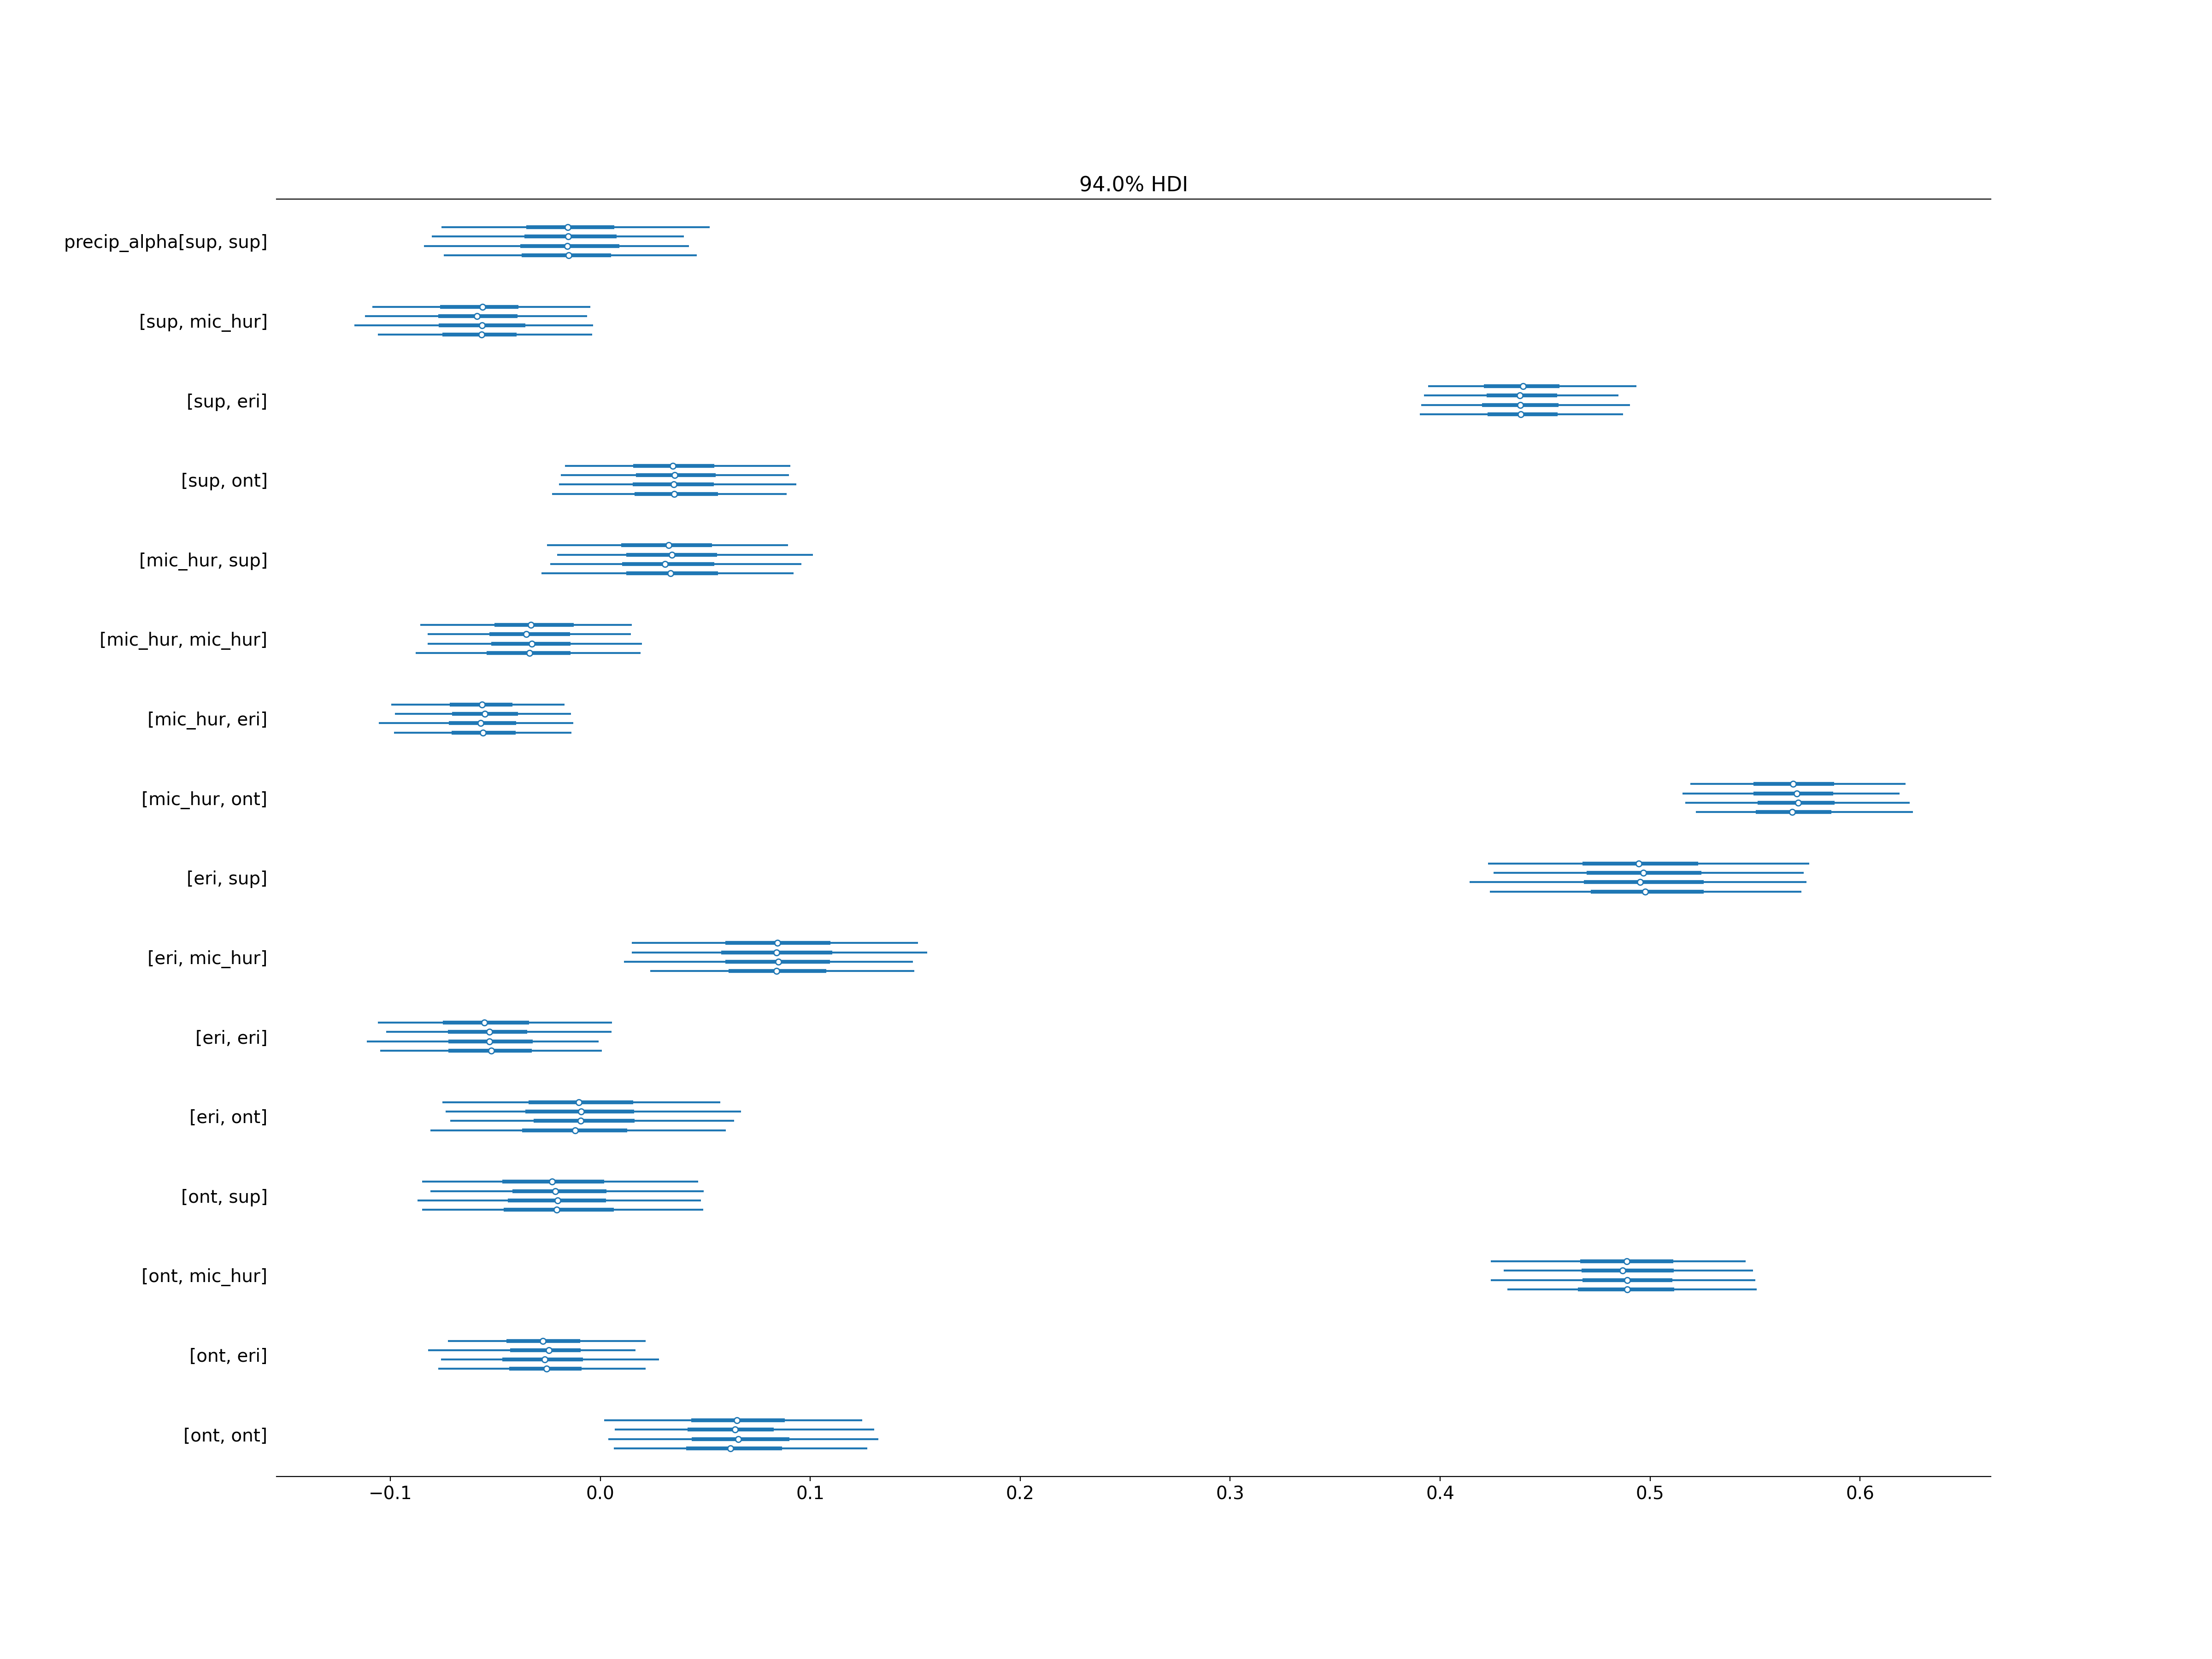

In [17]:
az.plot_forest(model.trace, var_names=["precip"], filter_vars="regex", figsize=(24, 18))

plt.show()